In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as py
from datetime import datetime as dt

In [2]:
#Read the datafile into a DataFrame
#The supplied files are clean, if you have data with nans or null values, you may have to do some extra cleaning up

df = pd.read_csv('c:/temp/bigcycledata.csv',dtype={'Watts':np.int,'Cadence':np.int,'HeartRate':np.int},parse_dates=True)
#df = pd.read_csv('c:/temp/cycledata.csv',parse_dates=True)

In [3]:
#Change the string datetime to a proper datetime format

df['datetime']=pd.to_datetime(df.Time)

# Set the elapsed duration between between each subsequent row 
# this would normally be 1 second, but sometimes it isn't

df['duration']=(df.datetime.shift(periods=-1)-df.datetime)

# Update NaT values to 0 seconds, as our dataframe is not allowed to contain non numeric values

df.loc[df['duration'].isnull(),'duration']=np.timedelta64(1,'s')

# Turn the duration into an integer value in seconds
df['durationseconds']=np.divide(df['duration'], np.timedelta64(1, 's'))


In [4]:
#Create a list of all the wattages measured on the ride if you want to be super granular down to the watt
##ws = pd.DataFrame(df.Watts.value_counts().sort_index())
##ws.reset_index(inplace=True)
##watts = ws.index.to_list()

#Alternatively you can also just create a series with the values 0....n where n = df.Watts.max()
#and optionally reduce the dataset to 5 or 10 watt intervals

#for the purposes of this exercise lets use a reduced set of points
watts = [i for i in range (10,501,10)]
if watts[0] > 0:
    watts.append(0)
if (max(watts)<df.Watts.max()):
    watts.append(df.Watts.max())
watts.sort()


#Peek into the uploaded data
display(df[['Time','Watts','duration','durationseconds']])



,Time,Watts,duration,durationseconds
0,2020/02/12 9:46:33,62,00:00:01,1.0
1,2020/02/12 9:46:34,62,00:00:01,1.0
2,2020/02/12 9:46:35,110,00:00:01,1.0
3,2020/02/12 9:46:36,132,00:00:01,1.0
4,2020/02/12 9:46:37,132,00:00:01,1.0
...,...,...,...,...
20502,2020/02/12 15:43:33,136,00:00:01,1.0
20503,2020/02/12 15:43:34,136,00:00:01,1.0
20504,2020/02/12 15:43:35,89,00:00:01,1.0
20505,2020/02/12 15:43:36,114,00:00:01,1.0


In [5]:
#Now collect all the unbroken runs at or over a given wattage
#e.g. if i ride for 10 seconds and my watts are 100,105,110,105,110,105,105,120,125,125 
# there will be 
#   1 run of 10 seconds at 100 watts or over
#   1 run of 9 seconds at 105 watts or over
#   3 runs of 1,1 and 3 seconds at 110 watts or over
#   1 run of 3 seconds at 120 watts or over
#   1 run of 2 seconds at 125 watts or over

start = dt.now()
print('Start at ',start)

bigseries = pd.DataFrame()

# Run through each entry in the "watts" series and collect all the runs
for index in watts:
    df['minwatts'] = index
    df['rowqualifies'] = (df.Watts >= df.minwatts) * 1
    
    #we will use df.previousrowqualifies to figure out whether a new run has started
    df['previousrowqualifies'] = df.rowqualifies.shift(periods = 1)
    df.loc[df['previousrowqualifies'].isnull(),'previousrowqualifies'] = 0
    
    #the below is a slightly subversive method to determine individual runs
    df['runstart'] = ((df.rowqualifies == 1) & (df.previousrowqualifies == 0)) * 1
    df['runid'] = df.runstart.cumsum()*df.rowqualifies
    
    #calculate the run duration for each run and store in a new dataframe
    runs = pd.DataFrame(df[df.runid!=0].groupby(['runid','minwatts']).duration.sum())
    #reset the index so that the index become ordinary columns
    runs.reset_index(inplace=True)
    #add runs for this wattage to the big container
    bigseries = bigseries.append(runs)

#reset the index so that the index become ordinary columns    
bigseries.reset_index(inplace=True)

end = dt.now()
dur = round(df.durationseconds.sum()/3600.0,3)
cats = len(watts)
print('  End at ',end,'\n  time taken for a ride of ',dur,' hours into ',cats,' power categories = ',end-start)

Start at  2020-03-04 20:57:00.750457
  End at  2020-03-04 20:57:04.256206 
  time taken for a ride of  5.951  hours into  52  power categories =  0:00:03.505749


In [6]:
#Now that we have a record of every "run" at or over a certain wattage, we can collate them all together
intervals = bigseries.groupby(['minwatts','duration']).count()
intervals.reset_index(inplace=True)

#rename some of the columns just to make the code a bit more readable
intervals.rename(columns={'runid':'numruns'},inplace=True)
intervals['intervalduration']=np.divide(intervals['duration'], np.timedelta64(1, 's'))
intervals['totalseconds']=intervals.intervalduration*intervals.numruns
intervals['totalminutes']=intervals.totalseconds/60


In [7]:
#now it becomes quite easy to turn the run data into a powercurve of some sorts
#please note this is not the same as a strava powercurve
powercurve = pd.DataFrame(intervals.groupby(['minwatts']).totalminutes.sum())
powercurve.reset_index(inplace=True)

#we can also determine the maximum interval length for a given wattage
maxintervals = pd.DataFrame(intervals.groupby(['minwatts']).intervalduration.max())
maxintervals.reset_index(inplace=True)

# Total time at a given output

In [8]:
import matplotlib.pyplot as py

Read this as follows (exmaple):
   Total time at an output of  80  watts or higher is 286 minutes
   Total time at an output of  420  watts or higher is 132 seconds


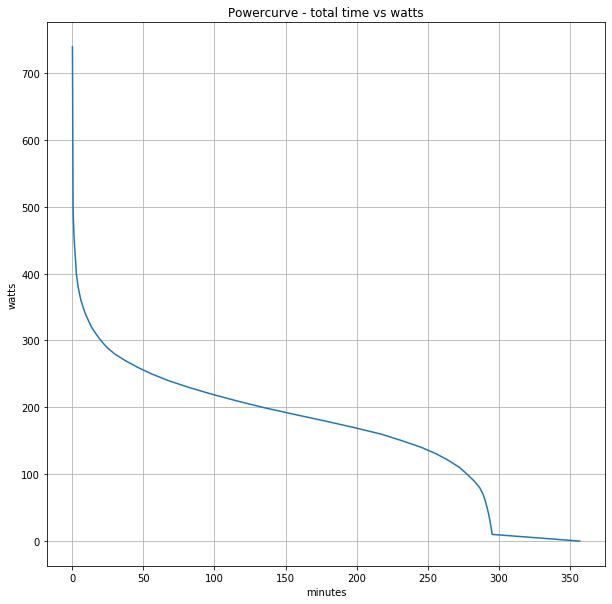

In [13]:
print('Read this as follows (exmaple):\n=====================')

row=powercurve.iloc[8]
print ('   Total time at an output of ',row.minwatts.astype(int),' watts or higher is',row.totalminutes.astype(int),'minutes')
row=powercurve.iloc[len(powercurve)-10]
print ('   Total time at an output of ',row.minwatts.astype(int),' watts or higher is',(row.totalminutes*60).astype(int),'seconds')




fig = py.figure(figsize = (10,10))
ax = fig.add_subplot(111)

py.xlabel('minutes')
py.ylabel('watts')
py.title('Powercurve - total time vs watts')
py.plot(powercurve.totalminutes,powercurve.minwatts)

py.grid()
py.show()

#Peek into the powercurve
#display (powercurve)

# Maxiumum continuous duration at a sustained (or higher) power level

Read this as follows:
   Maximum duration at a sustained output of  270  watts or higher is 46 seconds
   Maximum duration at a sustained output of  410  watts or higher is 8 seconds


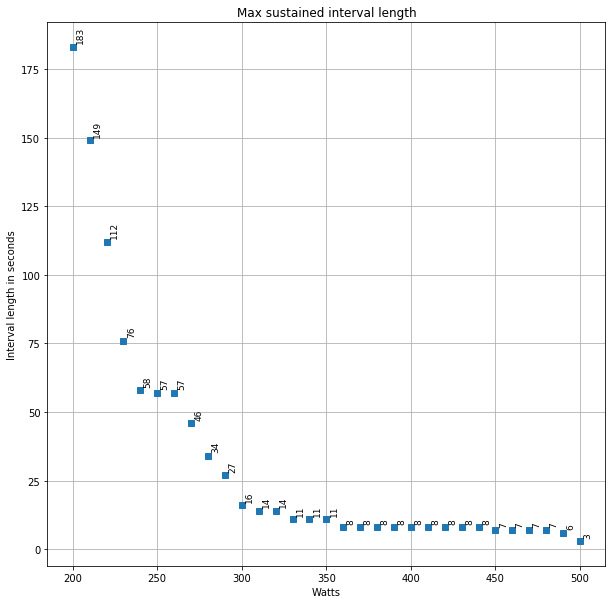

In [15]:
selectedintervals = maxintervals[(maxintervals.minwatts >= 200) & (maxintervals.minwatts <= 500)]


print('Read this as follows:\n=====================')
row=selectedintervals.iloc[7]
print ('   Maximum duration at a sustained output of ',row.minwatts.astype(int),' watts or higher is',row.intervalduration.astype(int),'seconds')
row=selectedintervals.iloc[len(selectedintervals)-10]
print ('   Maximum duration at a sustained output of ',row.minwatts.astype(int),' watts or higher is',row.intervalduration.astype(int),'seconds')

fig = py.figure(figsize = (10,10))
ax = fig.add_subplot(111)


py.plot(selectedintervals.minwatts,selectedintervals.intervalduration,'s')
py.xlabel('Watts')
py.ylabel('Interval length in seconds')
py.title('Max sustained interval length')

for index,row in selectedintervals.iterrows():
    py.text(row.minwatts+2,row.intervalduration+2,row.intervalduration.astype(int),rotation=90,fontSize=9)


py.grid()
py.show()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#    display (selectedintervals)